<a href="https://colab.research.google.com/github/austiezr/DS-Unit-2-Applied-Modeling/blob/master/module4-model-interpretation/LS_DS_234_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Lambda School Data Science

*Unit 2, Sprint 3, Module 4*

---

# Model Interpretation

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [x] Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.
- [x] Make at least 1 partial dependence plot to explain your model.
- [ ] Make at least 1 Shapley force plot to explain an individual prediction.
- [ ] **Share at least 1 visualization (of any type) on Slack!**

If you aren't ready to make these plots with your own dataset, you can practice these objectives with any dataset you've worked with previously. Example solutions are available for Partial Dependence Plots with the Tanzania Waterpumps dataset, and Shapley force plots with the Titanic dataset. (These datasets are available in the data directory of this repository.)

Please be aware that **multi-class classification** will result in multiple Partial Dependence Plots (one for each class), and multiple sets of Shapley Values (one for each class).

## Stretch Goals

#### Partial Dependence Plots
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

#### Shap Values
- [ ] Make Shapley force plots to explain at least 4 individual predictions.
    - If your project is Binary Classification, you can do a True Positive, True Negative, False Positive, False Negative.
    - If your project is Regression, you can do a high prediction with low error, a low prediction with low error, a high prediction with high error, and a low prediction with high error.
- [ ] Use Shapley values to display verbal explanations of individual predictions.
- [ ] Use the SHAP library for other visualization types.

The [SHAP repo](https://github.com/slundberg/shap) has examples for many visualization types, including:

- Force Plot, individual predictions
- Force Plot, multiple predictions
- Dependence Plot
- Summary Plot
- Summary Plot, Bar
- Interaction Values
- Decision Plots

We just did the first type during the lesson. The [Kaggle microcourse](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values) shows two more. Experiment and see what you can learn!

### Links

#### Partial Dependence Plots
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [pdpbox repo](https://github.com/SauceCat/PDPbox) & [docs](https://pdpbox.readthedocs.io/en/latest/)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

#### Shapley Values
- [Kaggle / Dan Becker: Machine Learning Explainability — SHAP Values](https://www.kaggle.com/learn/machine-learning-explainability)
- [Christoph Molnar: Interpretable Machine Learning — Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html)
- [SHAP repo](https://github.com/slundberg/shap) & [docs](https://shap.readthedocs.io/en/latest/)

In [0]:
%%capture

!pip3 install category_encoders
!pip3 install pandas-profiling
!pip3 install xgboost
!pip3 install pdpbox
!pip3 install shap
import pandas_profiling
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder, OneHotEncoder, TargetEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectKBest, mutual_info_classif, mutual_info_regression, f_classif
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import RidgeClassifierCV, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.decomposition import PCA
from xgboost import XGBClassifier, DMatrix
from pdpbox import pdp, info_plots
import shap

In [0]:
df = pd.read_csv('/Users/austie/Downloads/student/student-mat.csv', sep=';')
df1 = pd.read_csv('/Users/austie/Downloads/student/student-por.csv', sep=';')
df = df.append(df1, ignore_index=True)

In [0]:
%%capture

df['famsize'] = df['famsize'].map({'GT3': 1, 'LE3':0})
df['address'] = df['address'].map({'U':1, 'R':0})
df['Pstatus'] = df['Pstatus'].map({'A': 0, 'T':1})
for col in ['schoolsup', 'famsup', 'paid', 'activities', 
            'nursery', 'higher', 'internet', 'romantic']:
  df[col] = df[col].map({'yes':1, 'no':0})

for col in ['G1', 'G2', 'G3']:
  df[col] = df[col].replace({0: np.NaN})

dfmean = df[['G1', 'G2', 'G3']]
dfmean['Mean'] = dfmean.mean(axis=1)
df['Mean'] = dfmean['Mean']
df['Pass/Fail'] = df['G3']>=10

df['Improved'] = (df['G3']-df['Mean'])>0

df = df.drop(columns=['school'])

training, test = train_test_split(df, train_size=0.80, test_size=0.20, random_state=33)
train, val = train_test_split(training, train_size=0.80, test_size=0.20, random_state=33)

In [0]:
target = 'Improved'
features = train.drop(columns=[target, 'G1', 'G2', 'Mean']).columns
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]
X_training = training[features]
y_training = training[target]

In [0]:
encoder = OrdinalEncoder()
X_training_encoded = encoder.fit_transform(X=X_training)
X_test_encoded = encoder.fit_transform(X=X_test)

Train Accuracy: 0.6383233532934132

Test Accuracy: 0.7033492822966507


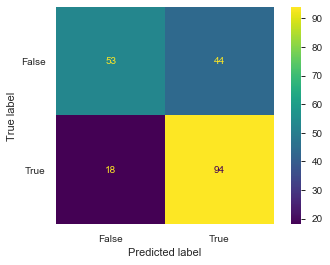

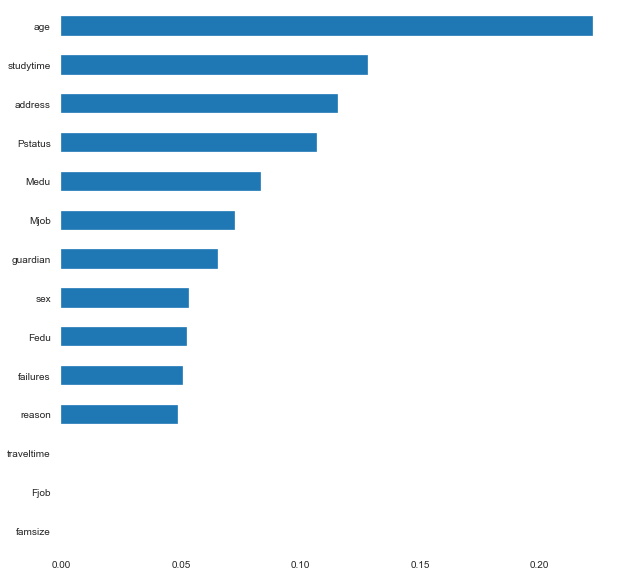

In [6]:
pipe = make_pipeline(
    TargetEncoder(),
    SimpleImputer(strategy='most_frequent'),
    PCA(26),
    SelectKBest(k=14),
    XGBClassifier(alpha=0.40790854859004644, base_score=0.5, booster='gbtree',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              eta=0.45456023198889695, gamma=2,
              learning_rate=0.6553237377561046, max_delta_step=0, max_depth=28,
              min_child_weight=76, missing=None, n_estimators=12, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=33,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
)

pipe.fit(X_training, y_training)

print(f'Train Accuracy: {pipe.score(X_training, y_training)}\n')
print(f'Test Accuracy: {pipe.score(X_test, y_test)}')

plot_confusion_matrix(estimator=pipe, X=X_test, y_true=y_test)


encoded_columns = X_training.columns

coefficients = pd.Series(pipe.named_steps.xgbclassifier.feature_importances_[:]
                         [:pipe.named_steps.selectkbest.k], 
                         encoded_columns[:pipe.named_steps.selectkbest.k])
plt.figure(figsize=(10,10))
coefficients.sort_values().plot.barh();

In [0]:
pdpdf = X_training_encoded.copy()
pdpdf['Improved'] = y_training

In [0]:
pdpfeature = 'studytime'
pdpfeatures = ['studytime', 'age']

(<Figure size 1080x720 with 5 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1256c6ed0>,
  'value_ax': <matplotlib.axes._subplots.AxesSubplot at 0x125871310>,
  'legend_ax': [<matplotlib.axes._subplots.AxesSubplot at 0x125539d50>,
   <matplotlib.axes._subplots.AxesSubplot at 0x1258e6150>]},
     x1  x2 display_column_1 display_column_2  value_lower_1  value_upper_1  \
 0    0   0           [1, 2)         [15, 16)            1.0            2.0   
 1    0   1           [1, 2)         [16, 17)            1.0            2.0   
 2    0   2           [1, 2)         [17, 18)            1.0            2.0   
 3    0   3           [1, 2)         [18, 22]            1.0            2.0   
 4    1   0           [2, 3)         [15, 16)            2.0            3.0   
 5    1   1           [2, 3)         [16, 17)            2.0            3.0   
 6    1   2           [2, 3)         [17, 18)            2.0            3.0   
 7    1   3           [2, 3)         [18, 22]            2

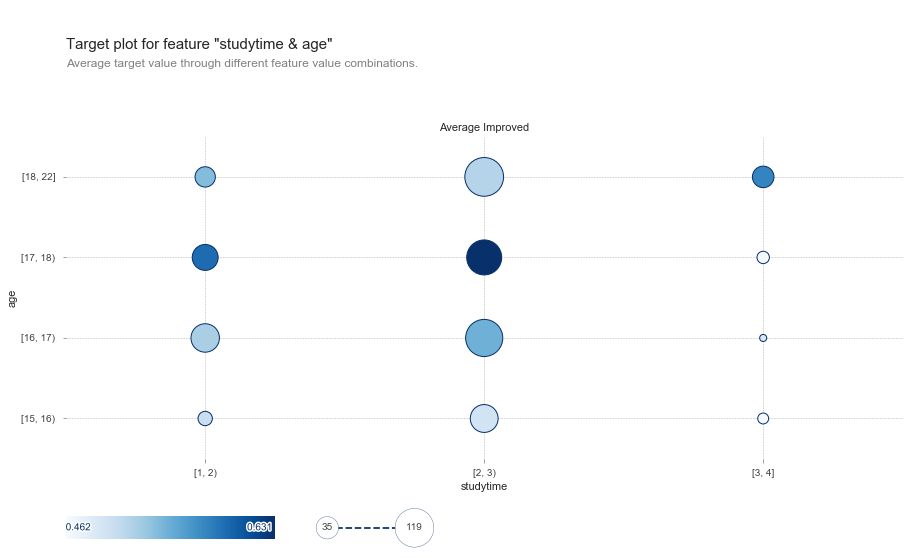

In [9]:
info_plots.target_plot_interact(pdpdf, features=pdpfeatures, feature_names=pdpfeatures, target=target)

(<Figure size 540x684 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1262e1f50>,
  'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x12636ccd0>})

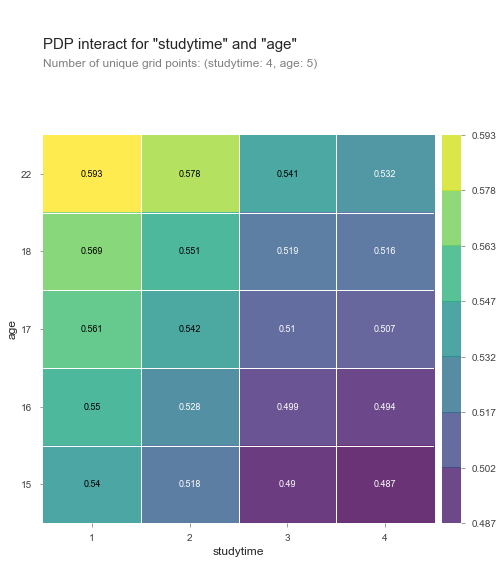

In [10]:
inter = pdp.pdp_interact(
    model=pipe,
    dataset=pdpdf,
    model_features=features,
    features=pdpfeatures
)

pdp.pdp_interact_plot(
    pdp_interact_out=inter,
    feature_names=pdpfeatures,
    plot_type='grid'
)

(-0.2, 0.15)

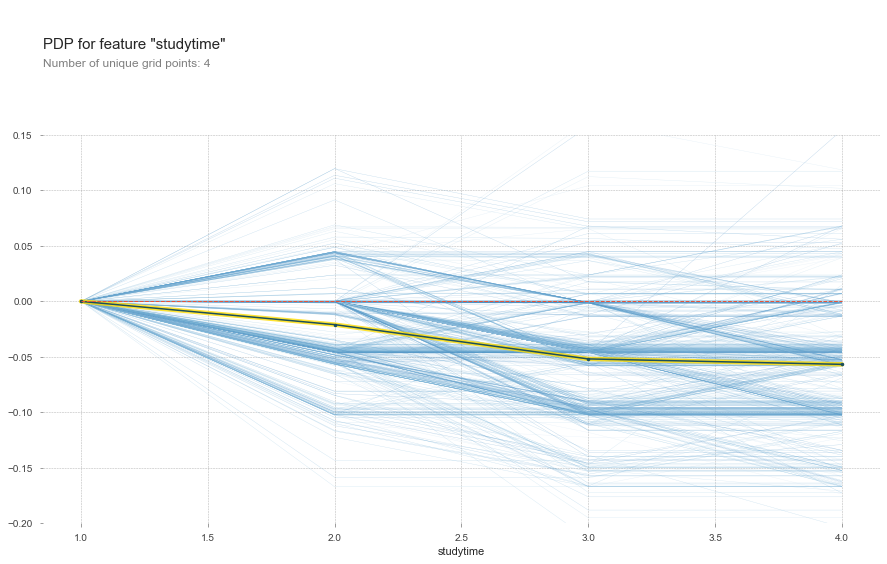

In [11]:
iso = pdp.pdp_isolate(
    model=pipe,
    dataset=pdpdf,
    model_features=features,
    feature=pdpfeatures[0],
)

pdp.pdp_plot(
    pdp_isolate_out=iso,
    feature_name=pdpfeatures[0],
    plot_lines=True
)

plt.ylim(-.2,.15)

(-0.15, 0.25)

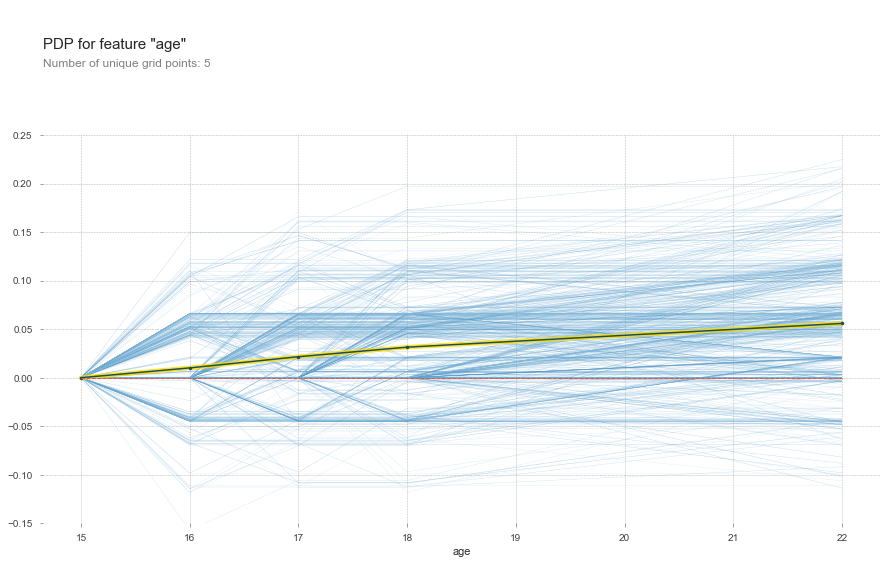

In [11]:
iso = pdp.pdp_isolate(
    model=pipe,
    dataset=pdpdf,
    model_features=features,
    feature=pdpfeatures[1],
)

pdp.pdp_plot(
    pdp_isolate_out=iso,
    feature_name=pdpfeatures[1],
    plot_lines=True
)

plt.ylim(-.15,.25)

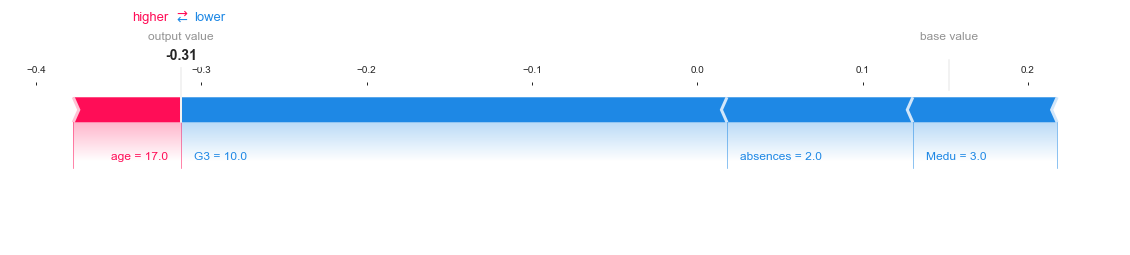

In [13]:
shap.initjs()

model = XGBClassifier(alpha=0.40790854859004644, base_score=0.5, booster='gbtree',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              eta=0.45456023198889695, gamma=2,
              learning_rate=0.6553237377561046, max_delta_step=0, max_depth=28,
              min_child_weight=76, missing=None, n_estimators=12, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=33,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

model.fit(X_training_encoded, y_training)

explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_training_encoded)

shap.force_plot(explainer.expected_value, shap_values[1,:], X_training_encoded.iloc[1,:], matplotlib=True)